### Data Source: https://www.kaggle.com/datasets/nisargchodavadiya/imdb-movie-reviews-with-ratings-50k

# 1. Installs

In [1]:
# pip installs

!pip install -q --upgrade torch==2.5.1+cu124 torchvision==0.20.1+cu124 torchaudio==2.5.1+cu124 --index-url https://download.pytorch.org/whl/cu124
!pip install -q --upgrade requests==2.32.3 bitsandbytes==0.46.0 transformers==4.48.3 accelerate==1.3.0 datasets==3.2.0 peft==0.14.0 trl==0.14.0 matplotlib wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.2/908.2 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 133.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 115.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━

# 2. Imports

In [2]:
# imports
# With much thanks to Islam S. for identifying that there was a missing import!

import os
import re
import math
from tqdm import tqdm
from google.colab import userdata
from huggingface_hub import login
import torch
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, set_seed, BitsAndBytesConfig
from datasets import load_dataset, Dataset, DatasetDict
import wandb
from peft import LoraConfig
from trl import SFTTrainer, SFTConfig
from datetime import datetime
import matplotlib.pyplot as plt

# 3. Model

In [3]:
# Constants

BASE_MODEL = "Qwen/Qwen2.5-0.5B"
PROJECT_NAME = "review_reader_highlevel"
HF_USER = "Aryannajjari"

# 4. Data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

data = pd.read_csv("/content/drive/MyDrive/LLM/imdb_sup.csv")
data.head()

Mounted at /content/drive


,Review,Rating,Sentiment
0,"Kurt Russell's chameleon-like performance, cou...",10,1
1,It was extremely low budget(it some scenes it ...,8,1
2,James Cagney is best known for his tough chara...,8,1
3,"Following the brilliant ""Goyôkiba"" (aka. ""Hanz...",8,1
4,One of the last classics of the French New Wav...,10,1


In [5]:
data = data.drop(columns=['Sentiment'], errors='ignore')
data.head()

,Review,Rating
0,"Kurt Russell's chameleon-like performance, cou...",10
1,It was extremely low budget(it some scenes it ...,8
2,James Cagney is best known for his tough chara...,8
3,"Following the brilliant ""Goyôkiba"" (aka. ""Hanz...",8
4,One of the last classics of the French New Wav...,10


In [6]:
# Data

DATASET_NAME = data
MAX_SEQUENCE_LENGTH = 350

In [7]:
# Run name for saving the model in the hub

RUN_NAME =  f"{datetime.now():%Y-%m-%d_%H.%M.%S}"
PROJECT_RUN_NAME = f"{PROJECT_NAME}-{RUN_NAME}"
HUB_MODEL_NAME = f"{HF_USER}/{PROJECT_RUN_NAME}"

In [9]:
# Hyperparameters for QLoRA

LORA_R = 16
LORA_ALPHA = 32
TARGET_MODULES = ["q_proj", "v_proj", "k_proj", "o_proj"]
LORA_DROPOUT = 0.1
QUANT_4_BIT = True

In [10]:
# Hyperparameters for Training

EPOCHS = 1
BATCH_SIZE = 4
GRADIENT_ACCUMULATION_STEPS = 1
LEARNING_RATE = 1e-4
LR_SCHEDULER_TYPE = 'cosine'
WARMUP_RATIO = 0.03
OPTIMIZER = "paged_adamw_32bit"

STEPS = 50
SAVE_STEPS = 2000
LOG_TO_WANDB = True

In [11]:
%matplotlib inline

In [12]:
HUB_MODEL_NAME

'Aryannajjari/review_reader_highlevel-2025-10-24_15.17.48'

In [13]:
# Log in to HuggingFace

hf_token = userdata.get('HF_TOKEN')
login(hf_token, add_to_git_credential=True)

In [14]:
from sklearn.utils import shuffle

data_shuffled = shuffle(data, random_state=42)

train = data_shuffled.iloc[:3000].copy() #3000 datapoints for training
test = data_shuffled.iloc[3000:5000].copy() #2000 datapoints for evaluating

print("Train size:", train.shape)
print("Test size:", test.shape)

Train size: (3000, 2)
Test size: (2000, 2)


In [15]:
# pick the right quantization

if QUANT_4_BIT:
  quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4"
  )
else:
  quant_config = BitsAndBytesConfig(
    load_in_8bit=True,
    bnb_8bit_compute_dtype=torch.bfloat16
  )

In [16]:
# Load the Tokenizer and the Model

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=quant_config,
    device_map="auto",
)
base_model.generation_config.pad_token_id = tokenizer.pad_token_id

print(f"Memory footprint: {base_model.get_memory_footprint() / 1e6:.1f} MB")

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/681 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

Memory footprint: 451.3 MB


In [17]:
from datasets import Dataset

# Prepare the text format expected by SFTTrainer
train["text"] = train.apply(lambda row: f"Review: {row['Review']}\nRating: {row['Rating']}", axis=1)
test["text"] = test.apply(lambda row: f"Review: {row['Review']}\nRating: {row['Rating']}", axis=1)

# Convert pandas DataFrames to HuggingFace Datasets
train_dataset = Dataset.from_pandas(train)
test_dataset = Dataset.from_pandas(test)

print(train_dataset[0])

{'Review': 'Having read all of the comments on this film I am still amazed at Fox\'s reluctance to release a full screen restored version in DVD. Yes, the history may be a bit inaccurate and it is certainly not as powerful as the book, BUT it was the 2nd film by Fox made in Real Cinemascope and the production values alone merit a restoration and distribution. I saw this film in second grade and it triggered my lifelong interest in all things Egyptian, culminating in my visiting Egypt 4 years ago! Amazing the power of film on a child\'s imagination, eh? In high school I read the book and made a promise to myself to one day take that dream trip. Now, true this film was made in the "old school" style, meaning that Egyptians were portrayed by pink skinned and blue-eyed Brits. However, has anyone seen the current HBO series "ROME"? Everything old is olde again. One can\'t imagine why in this day and age we are still casting actors mincing around as Mayfair aristocrats in Roman drag. Not one

# 5. Data Collator

In [18]:
from trl import DataCollatorForCompletionOnlyLM

response_template = "Rating:"
collator = DataCollatorForCompletionOnlyLM(response_template, tokenizer=tokenizer)

# 6. Preparation for Fine Tuning

In [19]:
# First, specify the configuration parameters for LoRA

lora_parameters = LoraConfig(
    lora_alpha=LORA_ALPHA,
    lora_dropout=LORA_DROPOUT,
    r=LORA_R,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=TARGET_MODULES,
)

# Next, specify the general configuration parameters for training

train_parameters = SFTConfig(
    output_dir=PROJECT_RUN_NAME,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=1,
    eval_strategy="no",
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    optim=OPTIMIZER,
    save_steps=SAVE_STEPS,
    save_total_limit=10,
    logging_steps=STEPS,
    learning_rate=LEARNING_RATE,
    weight_decay=0.001,
    fp16=False,
    bf16=True,
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=WARMUP_RATIO,
    group_by_length=True,
    lr_scheduler_type=LR_SCHEDULER_TYPE,
    run_name=RUN_NAME,
    max_seq_length=MAX_SEQUENCE_LENGTH,
    dataset_text_field="text",
    save_strategy="steps",
    hub_strategy="every_save",
    push_to_hub=True,
    hub_model_id=HUB_MODEL_NAME,
    hub_private_repo=True
)


fine_tuning = SFTTrainer(
    model=base_model,
    train_dataset=train_dataset,
    peft_config=lora_parameters,
    args=train_parameters,
    data_collator=collator
  )

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

# 7. Fine Tuning

In [20]:
# Fine-tune!
fine_tuning.train()

# Push our fine-tuned model to Hugging Face
fine_tuning.model.push_to_hub(PROJECT_RUN_NAME, private=True)
print(f"Saved to the hub: {PROJECT_RUN_NAME}")

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: aryan-najjari (aryan-najjari-the-university-of-texas-at-dallas) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.12/dist-packages/trl/trainer/utils.py:139: UserWarning: Could not find response key `Rating:` in the following instance: Review: INSPECTOR GADGET (1999) **<br /><br />Starring: Matthew Broderick, Rupert Everett, Joely Fisher, Andy Dick, Dabney Coleman Director: David Kellogg 80 minutes Rated PG<br /><br />By Blake French:<br /><br />Disney's new film, "Inspector Gadget" is about a cop named John who survives a major accident and is saved by a state of the art experimental operation that turns him into a robotic machine-like agent who has tools and contraptions of all sorts built into his body at his use when he says "Go Go," only to be called Inspector Gadget!<br /><br />The actual movie's structure is much like the body formation of Inspector Gadget himself. It is noisy, fragmented, energetic and consist of a bunch of half hearted contraptions thrown together to make something that doesn't have much in common with anything else present. The film is basically a s

Step,Training Loss
50,0.537200
100,0.525400
150,0.476100
200,0.411300
250,0.417900
300,0.432200
350,0.436300
400,0.409500
450,0.395000
500,0.425500


/usr/local/lib/python3.12/dist-packages/trl/trainer/utils.py:139: UserWarning: Could not find response key `Rating:` in the following instance: Review: Before I start, let me say that my experience of this movie might have been influenced by the dubbing, which I gather from other comments was the original one which is considered inferior by some. So, it is entirely possible that subtitles or the apparently new DVD version would make a difference. I have also not read the corresponding book; I'm only familiar with one other Japanese manga and might be lacking cultural context.<br /><br />Potential minor spoilers ahead.<br /><br />I usually like darkly tinged science fiction stories (the likes of Blade Runner, 12 Monkeys, etc.), but I did not enjoy this movie at all. While it started out mildly intriguing, it became tedious by the time it was only half-way finished. There are all sorts of problems; let's start with what is probably the most severe: the dialogue. The characters seem unabl

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...adapter_model.safetensors: 100%|##########| 8.68MB / 8.68MB            

Saved to the hub: review_reader_highlevel-2025-10-24_15.17.48


# 8. Preparation for Evaluation

In [21]:
def extract_rating(s):
    if "Rating:" in s:
        contents = s.split("Rating:")[1]
        match = re.search(r"\d+", contents)
        return int(match.group()) if match else None
    return None

In [22]:
extract_rating("Review: This movie was amazing and emotional. Rating: 9")

9

In [23]:
from transformers import pipeline


MODEL_PATH = "Aryannajjari/review_reader_highlevel-2025-10-24_15.17.48"

# Load model and tokenizer
pipe = pipeline("text-generation", model=MODEL_PATH, tokenizer=BASE_MODEL)

adapter_config.json:   0%|          | 0.00/741 [00:00<?, ?B/s]

Device set to use cuda:0


In [24]:
predictions = []
true_ratings = []

for i, row in test.iterrows():
    review = row["Review"]
    true_rating = int(row["Rating"])

    # Build prompt
    prompt = f"Review: {review}\nRating:"

    # Generate model output
    result = pipe(prompt, max_new_tokens=5, temperature=0.2)[0]["generated_text"]

    # Extract rating
    predicted = extract_rating(result)

    # Save results
    predictions.append(predicted)
    true_ratings.append(true_rating)

    # Optional: progress display
    if i % 20 == 0:
        print(f"Processed {i} reviews...")


/usr/local/lib/python3.12/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Processed 44340 reviews...


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Processed 48720 reviews...
Processed 15400 reviews...
Processed 12140 reviews...
Processed 3180 reviews...
Processed 17020 reviews...
Processed 28280 reviews...
Processed 48920 reviews...
Processed 41440 reviews...
Processed 31460 reviews...
Processed 30420 reviews...
Processed 28780 reviews...
Processed 8920 reviews...
Processed 8020 reviews...
Processed 39100 reviews...
Processed 2980 reviews...
Processed 21680 reviews...
Processed 42860 reviews...
Processed 15000 reviews...
Processed 41100 reviews...
Processed 19140 reviews...
Processed 480 reviews...
Processed 12980 reviews...
Processed 28680 reviews...
Processed 22140 reviews...
Processed 20500 reviews...
Processed 49620 reviews...
Processed 32840 reviews...
Processed 39300 reviews...
Processed 35220 reviews...
Processed 16780 reviews...
Processed 36500 reviews...
Processed 40020 reviews...
Processed 1480 reviews...
Processed 4980 reviews...
Processed 24640 reviews...
Processed 6100 reviews...
Processed 7460 reviews...
Processed 8

# 9. Metrics

In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import math

# Filter out any cases where the model failed to produce a numeric prediction
filtered = [(t, p) for t, p in zip(true_ratings, predictions) if p is not None]
if len(filtered) == 0:
    raise ValueError("No valid predictions to evaluate (all predictions were None).")

true_ratings_filtered = [int(t) for t, _ in filtered]
predictions_filtered  = [int(p) for _, p in filtered]

mae = mean_absolute_error(true_ratings_filtered, predictions_filtered)
mse = mean_squared_error(true_ratings_filtered, predictions_filtered)
rmse = math.sqrt(mse)


if len(true_ratings_filtered) > 1 and np.std(predictions_filtered) > 0 and np.std(true_ratings_filtered) > 0:
    corr = np.corrcoef(true_ratings_filtered, predictions_filtered)[0, 1]
else:
    corr = float("nan")

print(f"📊 MAE:  {mae:.3f}")
print(f"📈 RMSE: {rmse:.3f}")
print(f"🔗 Corr: {corr:.3f}")


📊 MAE:  1.876
📈 RMSE: 4.381
🔗 Corr: 0.516


# 10. Visualization

Green (≤1 difference): 60.49%
Yellow (=2 difference): 11.80%
Red (>2 difference): 27.71%


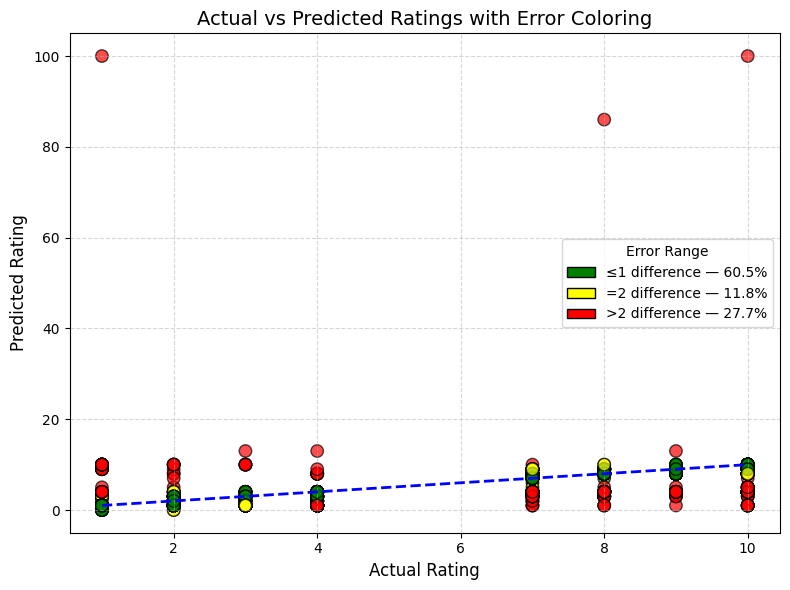

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Convert to numpy arrays for convenience
y_true = np.array(true_ratings_filtered)
y_pred = np.array(predictions_filtered)

# Calculate absolute rating difference
error = np.abs(y_pred - y_true)

# Categorize errors
color_labels = []
for err in error:
    if err <= 1:
        color_labels.append('green')     # accurate or ±1 difference
    elif err == 2:
        color_labels.append('yellow')    # off by 2
    else:
        color_labels.append('red')       # off by more than 2

# Calculate and display percentages ---
total = len(color_labels)
green_pct = (color_labels.count('green') / total) * 100
yellow_pct = (color_labels.count('yellow') / total) * 100
red_pct = (color_labels.count('red') / total) * 100

print(f"Green (≤1 difference): {green_pct:.2f}%")
print(f"Yellow (=2 difference): {yellow_pct:.2f}%")
print(f"Red (>2 difference): {red_pct:.2f}%")

# --- Visualization ---
plt.figure(figsize=(8,6))

# Scatter plot: actual vs predicted
plt.scatter(y_true, y_pred, c=color_labels, alpha=0.7, edgecolors='k', s=80)

# Diagonal line for perfect prediction
plt.plot([y_true.min(), y_true.max()],
         [y_true.min(), y_true.max()],
         'b--', lw=2, label='Perfect Prediction')

plt.xlabel("Actual Rating", fontsize=12)
plt.ylabel("Predicted Rating", fontsize=12)
plt.title("Actual vs Predicted Ratings with Error Coloring", fontsize=14)

# Legend showing color meaning and percentages
legend_elements = [
    Patch(facecolor='green', edgecolor='k', label=f'≤1 difference — {green_pct:.1f}%'),
    Patch(facecolor='yellow', edgecolor='k', label=f'=2 difference — {yellow_pct:.1f}%'),
    Patch(facecolor='red', edgecolor='k', label=f'>2 difference — {red_pct:.1f}%')
]
plt.legend(handles=legend_elements, title="Error Range", loc="best")

plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()
